In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import ast
import re
import datetime
from tqdm import tqdm
from operator import itemgetter

import seaborn as sb
from google.colab import files
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import display

import scipy.stats as stats
from textblob import TextBlob
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

%matplotlib inline

import nltk

nltk.download('popular');

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

# Step 0 - Importing Data

In [2]:
# Please UPLOAD the data to session storage from files menu with the same name as 'all_tweets.csv' and 'following_data.csv

raw_df = pd.read_csv('all_tweets.csv', on_bad_lines='skip', encoding='latin-1')
following_df = pd.read_csv('following_data.csv', on_bad_lines='skip', encoding='latin-1')

raw_df.head()

,account,date,tweet
0,akshaykumar,29/10/2022,à¤¸à¤¾à¤°à¥ à¤¸à¤µà¤¾à¤²à¥à¤ à¤à¥ à¤à¤µà...
1,akshaykumar,29/10/2022,Amazingly cute review. Thanks for sharing. Par...
2,akshaykumar,29/10/2022,Khush raho Aqsa beta. God bless you.
3,akshaykumar,28/10/2022,à¤à¤¸ à¤¬à¤¾à¤° à¤­à¥ à¤ à¤à¥à¤à¤¾à¤ à¤...
4,akshaykumar,27/10/2022,à¤¦à¤¿à¤² à¤à¤¼à¥à¤¶ à¤¹à¥ à¤à¤¯à¤¾ à¤¯à¤¹...


# Step1 - Data Processing

In [3]:
def is_ascii(txt):
    try:
        return str(txt).isascii()
    except:
        return False
        

#Removing links
raw_df['tweet'] = raw_df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

#Removing other language tweets        
df = raw_df[raw_df['tweet'].apply(is_ascii)]

# Removing if account doesn't match
all_influencers = ['BarackObama', 'BillGates', 'elonmusk', 'BeingSalmanKhan', 'britneyspears', 'BrunoMars', 'BTS_twt', 'akshaykumar', 'Cristiano', 'ddlovato', 'Drake', 'Harry_Styles', 'iamsrk', 'imVkohli', 'jimmyfallon', 'JLo', 'jtimberlake', 'justinbieber', 'katyperry', 'KimKardashian', 'KingJames', 'KylieJenner', 'ladygaga', 'MileyCyrus', 'narendramodi', 'NiallOfficial', 'Oprah', 'PMOIndia', 'rihanna', 'selenagomez', 'shakira', 'SrBachchan', 'taylorswift13', 'TheEllenShow']
df = df[df.account.isin(all_influencers)]

reindexed_data = df['tweet']
reindexed_data.index = df['date']

print('total tweets:', len(df), '\n\n')
df.head()

total tweets: 269277 




,account,date,tweet
2,akshaykumar,29/10/2022,Khush raho Aqsa beta. God bless you.
5,akshaykumar,26/10/2022,Thank you for celebrating your Diwali with us ...
11,akshaykumar,26/10/2022,Thank you
17,akshaykumar,24/10/2022,Iss saal Diwali hogi Action aur Adventure se b...
20,akshaykumar,22/10/2022,All set? Because the biggest adventure of the ...


In [4]:
following_df = following_df[following_df.account.isin(all_influencers)]
connected_following_df = following_df[(following_df.account.isin(all_influencers)) & (following_df.following_account.isin(all_influencers))]

connected_following_df.head()

,following_account,account
590252,BTS_twt,justinbieber
590266,katyperry,justinbieber
619102,elonmusk,justinbieber
753481,narendramodi,justinbieber
763898,Harry_Styles,justinbieber


# Data Visualization

Network Analysis using following list

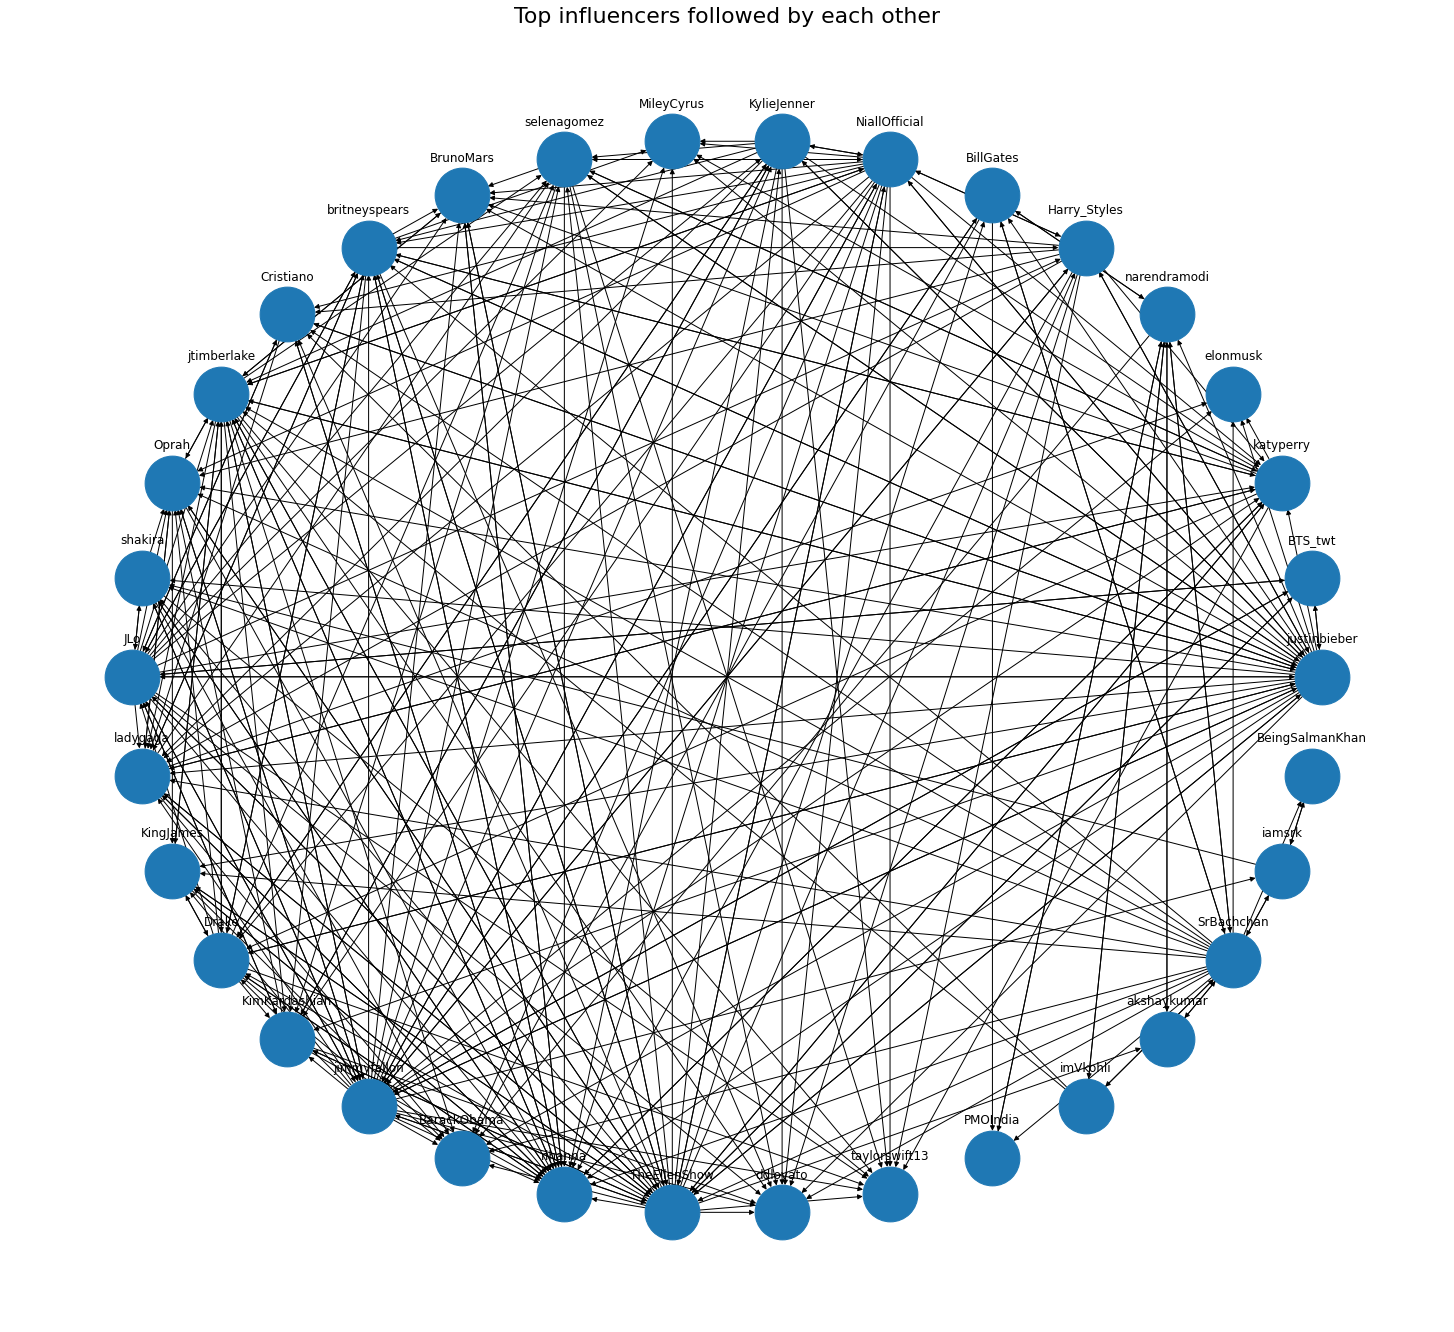

In [5]:
def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}
    

following_graph = nx.from_pandas_edgelist(connected_following_df,source='account', target='following_account', create_using=nx.DiGraph())

plt.figure(figsize=(20,18))

pos = nx.circular_layout(following_graph)
pos_nodes = nudge(pos, 0, 0.07) 

nx.draw(following_graph, pos, node_size=3000, with_labels=False)
nx.draw_networkx_labels(following_graph, pos=pos_nodes)  

plt.title('Top influencers followed by each other', fontsize=22)
plt.savefig("plot.png")
plt.show()

In [6]:
network_density = nx.density(following_graph)
print('Network density : ', network_density, '\n')

degree_dict = dict(following_graph.degree(following_graph.nodes()))
nx.set_node_attributes(following_graph, degree_dict, 'degree')

sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

print('Top 10 account by degree : \n')
for d in sorted_degree[:10]:
    print(d[0], ' -> ', d[1])

Network density :  0.25935828877005346 

Top 10 account by degree : 

TheEllenShow  ->  40
justinbieber  ->  38
jimmyfallon  ->  36
JLo  ->  29
rihanna  ->  29
jtimberlake  ->  28
NiallOfficial  ->  27
SrBachchan  ->  24
britneyspears  ->  23
ladygaga  ->  22


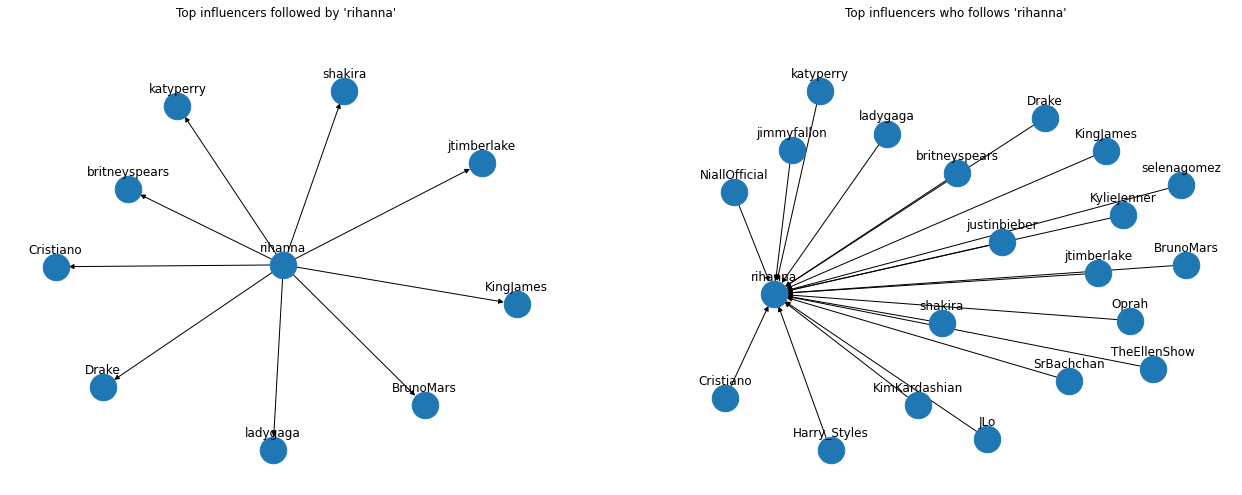

In [7]:
#Network Analysis of a single account

# test_list = ['BillGates', 'TheEllenShow', 'Oprah, 'rihanna']

account_name = 'rihanna'
connected_following_single_account_df = connected_following_df[(connected_following_df['account'].isin([account_name]))]
following_single_graph = nx.from_pandas_edgelist(connected_following_single_account_df,source='account', target='following_account', create_using=nx.DiGraph())


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(22,8))

pos = nx.fruchterman_reingold_layout(following_single_graph)
pos_nodes = nudge(pos, 0, 0.09) 

ax1.title.set_text(f'Top influencers followed by \'{account_name}\'\n\n')
nx.draw(following_single_graph, pos, node_size=700, with_labels=False, ax=ax1)
nx.draw_networkx_labels(following_single_graph, pos=pos_nodes, ax=ax1)  


connected_following_single_account_df = connected_following_df[(connected_following_df['following_account'].isin([account_name]))]
following_single_graph = nx.from_pandas_edgelist(connected_following_single_account_df,source='account', target='following_account', create_using=nx.DiGraph())

pos = nx.fruchterman_reingold_layout(following_single_graph)
pos_nodes = nudge(pos, 0, 0.09) 

ax2.title.set_text(f'Top influencers who follows \'{account_name}\'\n\n')
nx.draw(following_single_graph, pos, node_size=700, with_labels=False, ax=ax2)
nx.draw_networkx_labels(following_single_graph, pos=pos_nodes, ax=ax2)  

plt.show();


Tweet Analysis by frequent words

In [8]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    vectorized_tweets = count_vectorizer.fit_transform(text_data.values.astype('U'))
    vectorized_total = np.sum(vectorized_tweets, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_tweets.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])
    

count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=10, count_vectorizer=count_vectorizer, text_data=reindexed_data)

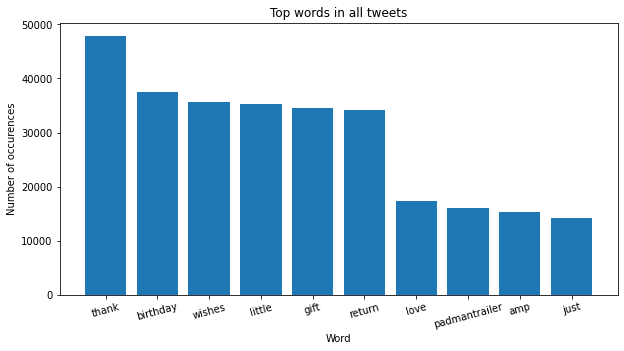

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation=15);
ax.set_title('Top words in all tweets');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

# Extracting top topics by Infuencers

In [10]:
def get_keys(topic_matrix):
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys


def keys_to_counts(keys):
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)
    

def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    
    top_word_indices = []

    for topic in range(n_topics):
        temp_vector_sum = 0

        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]

        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)

    top_words = []

    for topic in top_word_indices:
        topic_words = []

        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        
        top_words.append(" ".join(topic_words))   

    return top_words


def get_topics(input_tweets, n_topics, n_words_per_topic):
    small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
    small_text_sample = input_tweets.sample(n=len(input_tweets), random_state=0).values
    small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

    lsa_model = TruncatedSVD(n_components=n_topics)
    lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

    lsa_keys = get_keys(lsa_topic_matrix)
    lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

    top_n_topics = get_top_n_words(n_words_per_topic, lsa_keys, small_document_term_matrix, small_count_vectorizer)
    
    return top_n_topics, lsa_categories, lsa_counts


def get_topics_by_influencer(name, input_df):
    input_tweets = input_df['tweet']
    input_tweets.index = input_df['date']

    top_n_topics, lsa_categories, lsa_counts = get_topics(input_tweets, n_topics, n_words_per_topic)

    for i in range(len(top_n_topics)):
        print(name, " -> Topic {}: ".format(i+1), top_n_topics[i])



In [11]:
n_topics = 5
n_words_per_topic = 3

for influencer in all_influencers:
    try:
        influencers_df = df[df['account'].isin([influencer])]
        get_topics_by_influencer(influencer, influencers_df)
    except:
        pass

    print('\n')

BarackObama  -> Topic 1:  president obama watch
BarackObama  -> Topic 2:  health care americans
BarackObama  -> Topic 3:  change actonclimate climate
BarackObama  -> Topic 4:  climate change health
BarackObama  -> Topic 5:  senate doyourjob leaders


BillGates  -> Topic 1:  world great polio
BillGates  -> Topic 2:  world chart measles
BillGates  -> Topic 3:  energy climate need
BillGates  -> Topic 4:  health global countries
BillGates  -> Topic 5:  people live year


elonmusk  -> Topic 1:  amp tesla spacex
elonmusk  -> Topic 2:  tesla model car
elonmusk  -> Topic 3:  spacex erdayastronaut starship
elonmusk  -> Topic 4:  yes teslaownerssv flcnhvy
elonmusk  -> Topic 5:  good just great


BeingSalmanKhan  -> Topic 1:  day ho jai
BeingSalmanKhan  -> Topic 2:  skfilmsofficial ke ka
BeingSalmanKhan  -> Topic 3:  hai best toh
BeingSalmanKhan  -> Topic 4:  bharat skfilmsofficial thank
BeingSalmanKhan  -> Topic 5:  sohailkhan thejaevents jaevents


britneyspears  -> Topic 1:  brit rt love
britn

# Extracting yearly topics by an influencer (Bill Gates)

In [12]:
n_topics = 5
n_words_per_topic = 4


def get_topics_by_influencer_and_year(name, _year, input_df):
    input_tweets = input_df['tweet']
    input_tweets.index = input_df['date']

    top_n_topics, lsa_categories, lsa_counts = get_topics(input_tweets, n_topics, n_words_per_topic)

    # for i in range(len(top_n_topics)):
    #     print(name, " : ", _year,  " -> Topic {}: ".format(i+1), top_n_topics[i])

    labels = [top_n_topics[i] for i in lsa_categories]
    fig, ax = plt.subplots(figsize=(8,4))
    ax.bar(lsa_categories, lsa_counts);
    ax.set_xticks(lsa_categories);
    ax.set_xticklabels(labels, rotation=10);
    ax.set_ylabel('Number of tweets');
    ax.set_title(f'Extracted topic from {name} ({_year})');
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


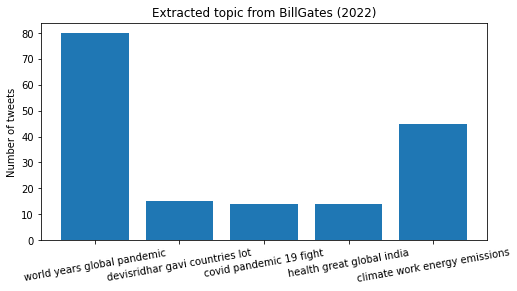

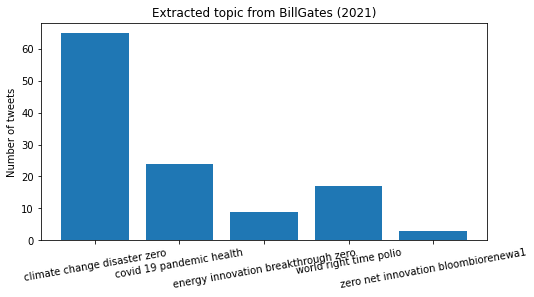

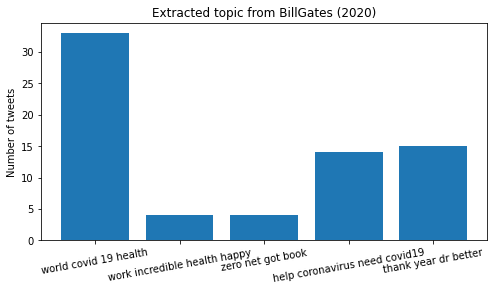

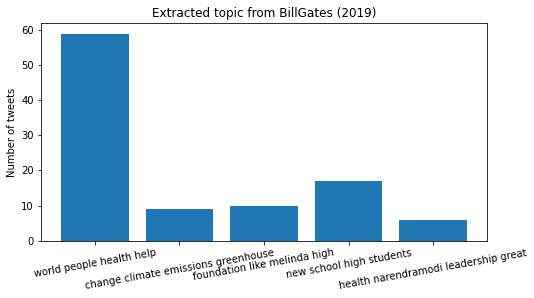

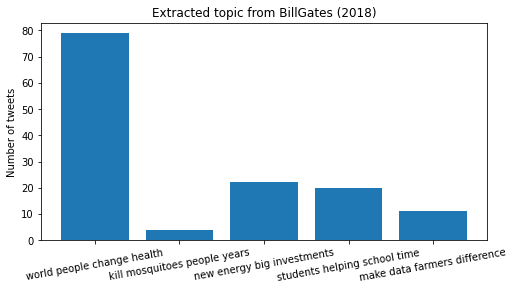

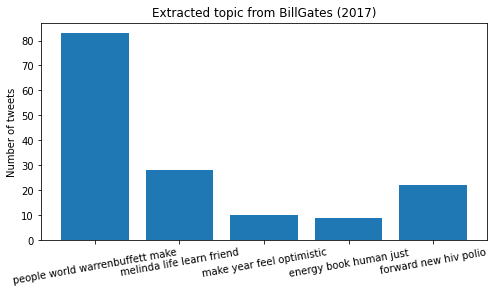

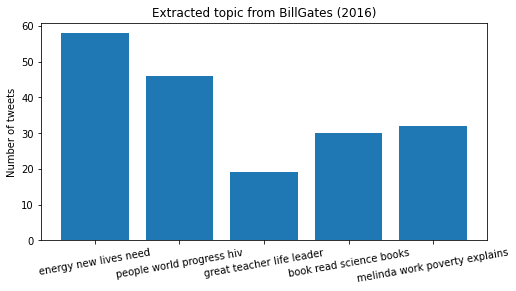

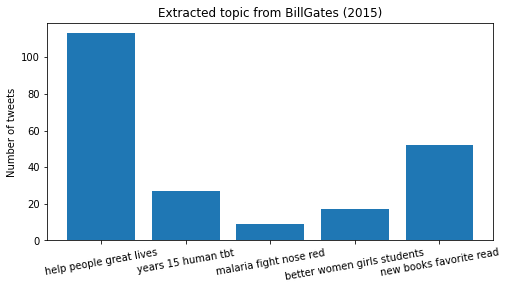

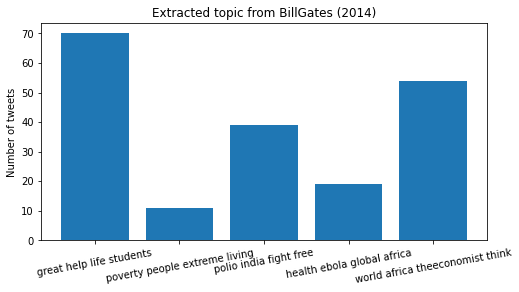

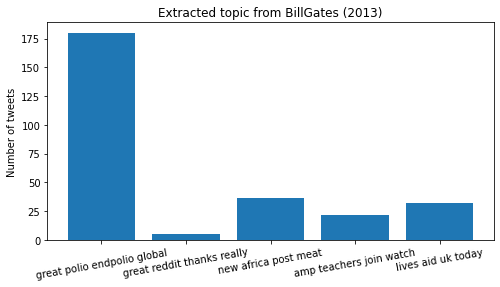

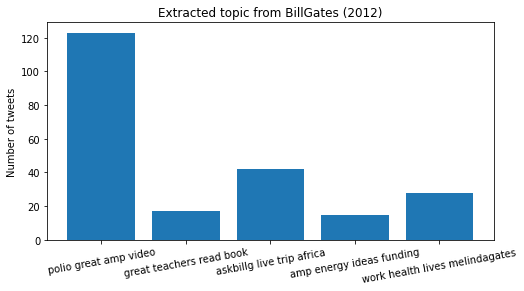

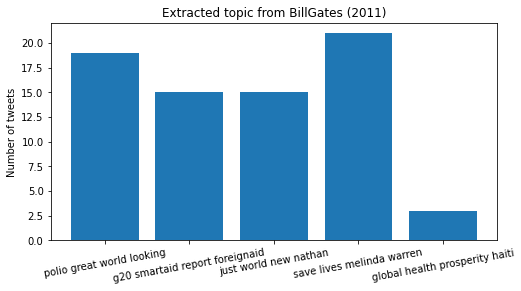

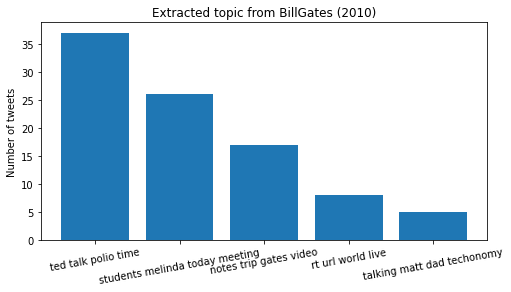

In [13]:
# test_list = ['BarackObama', 'BillGates', 'elonmusk']
influencer_name = 'BillGates'

influencers_df = df[df['account'].isin([influencer_name])]
influencers_df['date'] = pd.to_datetime(influencers_df['date'])
year_list = influencers_df['date'].dt.year.unique().tolist()
print('\n\n')

for _year in year_list:
    try:
        influencers_year_df = influencers_df[influencers_df['date'].dt.year == _year]
        get_topics_by_influencer_and_year(influencer_name, _year, influencers_year_df)
        print('\n')
    except:
        pass